# *Statistics coded:* Living conditions in Europe - poverty and social exclusion

Prepared by [**Lasai Barreñada**](https://github.com/LasaiBarrenada) (EMOS).

This notebook aims at reproducing the figures of the original *Statistics Expplained* article on [**Living conditions in Europe - poverty and social exclusion**](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Living_conditions_in_Europe_-_poverty_and_social_exclusion).

## Notebook settings

### Imports

While this notebook is intended to run with [`Python 3.8`](https://docs.python.org/3/contents.html) kernel, the following libraries (modules/packages) are used in this notebook:
- [`numpy`](https://numpy.org/) and [`pandas`](https://pandas.pydata.org/) for handling data,
- [`EurostatApiClient`](https://pypi.org/project/eurostatapiclient/) for connecting to [_Eurostat_ API](https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/rest-request),
- [`matplotlib`](https://matplotlib.org/contents.html) and [`seaborn`](https://seaborn.pydata.org/) for plotting,
- [`geopandas`](https://geopandas.org/) and [`shapely`](https://shapely.readthedocs.io/en/latest/manual.html) for handling geospatial datasets,
- [`folium`](https://python-visualization.github.io/folium/) and [`branca`](https://github.com/python-visualization/branca) for geo visualisation.

Let's import them all at once:

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import requests
from eurostatapiclient import EurostatAPIClient

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator

import folium
from folium import plugins as foliump
import branca.colormap as bcm
from shapely import geometry

### API client setup

We setup (once for all) the API client that will be used throughout the notebook.

In [2]:
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In the following, we consider using dictionaries indexed by the names of the datasets, each key in `ds` will be used further on in the plotting of the figures:

In [3]:
ds = ['ilc_peps01_ths',  'ilc_peps01_pc',     'ilc_peps01_sex',    'ilc_peps01_age', 
      'hlth_dpe010_lim', 'ilc_peps02_activ',  'ilc_peps04_edu',    'ilc_peps01_df3',
      'ilc_peps13_urb', 'ilc_li02_total',     'ilc_lvhl11_lowork', 'ilc_mddd11_material',
      'ilc_li02_rate',   'ilc_li01_treshold', 'ilc_li02_bef',      'ilc_li48_aft',
      'ilc_li02_aft',    'ilc_li10_bef',      'ilc_li22b_map'] 

In the above, each dataset is related to a _Eurostat_ table which is the first part of its name (_e.g. *ilc_peps01*). In the related _Eurostat_ page for the table it is possible to consult all the possible parameters to be extracted. 

The _Eurostat_ source data are referenced throughout the notebook. 

In [4]:
def getTableName (dsname):
    return '_'.join(dsname.split('_')[:2])

table = dict.fromkeys(ds, {})
[table.update({ds: getTableName(ds)}) for ds in table.keys()];

For instance, declaring the list of parameters used for:
* fetching the datasets
* plotting keywords 
* plotting legend keywords


In [5]:
params = dict.fromkeys(ds, {})
df = dict.fromkeys(ds)
kw_plot =dict.fromkeys(ds,{})
kw_legend = dict.fromkeys(ds, {})
legend = dict.fromkeys(ds ,{})

We create dictionary structures to set the layout for labels and plots. By editing this values you will be able to set the properties that you want:

In [6]:
legend_properties = {'weight':'bold','size':'10'}
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 
                   'CZ': 'Czechia', 'DE': 'Germany', 'DK':'Denmark', 'EE':'Estonia', 
                   'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France', 
                   'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 
                   'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT':'Malta', 
                   'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 
                   'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia', 'UK':'United Kingdom', 
                   'EU28': 'EU-28', 'TR':'Turkey','CH':'Switzerland', 'IS':'Iceland', 
                   'MK':'North Macedonia','ME':'Montenegro', 'NO':'Norway', 'RS': 'Serbia'}
# countries_abbr = list(countries_names.keys())
countries_abbr = ['AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI',             
                  'FR','HR','HU','IE','IT','LT','LU','LV','NV','NL','PL',
                  'PT','RO','SE','SI','SK','UK','MT', 'EU28']

title_properties = {'fontsize':15,'fontweight' : 'bold', 'horizontalalignment' : 'left', 'x' : 0, 'y' :1.05}
grid_properties = {'which' : 'major', 'axis' : 'y', 'color' : 'grey', 'linestyle' : 'dashed', 'alpha' : 0.4}

### Custom functions

* `setvaluegraph` sets the value of the plotted bar/scatter in the figure

In [7]:
def setvaluegraph (value # list of the values 
                   ,axis # axis where we represent the value
                   , horizontal # True if the graph is horizontal and False if it's vertical 
                   ,xpos = 0 # parameter to adjust the position of the value on x axis
                   ,ypos= 0 # parameter to adjust the position of the value on y axis
                   , fontsize= 8
                   , color = 'b'
                   , weight = 'normal'
                   , style = 'normal'
                   , form = '{}'): # format of the desired value e.g {:.1f}% for pcg
    # This function allows to set the value of the represented graph in the graph next to the bar/scatter
    for i,v in enumerate(value):
        if horizontal:
            x, y = v, i
        else:
            x, y = i, v
        axis.text(x-xpos, y-ypos, str(form.format(v)), fontsize = fontsize, 
                   color = color, weight = weight, style = style)
    return axis

* `lastyearvalue` searches in the given dataframe if there is any missing value for a given year and if so it remplaces it with the existing value of the most recent year. It accepts the following parameters:
  * `currentdf` : data with the values of the current year,
  * `columncurrent` :  column of the dataframe for which we want to see if there are missing values,
  * `completedf` : dataframe with data from previous years,
  * `year` : year to make the fetch,
  * `label` : in case that there are more than category for the values, the category column.

In [8]:
def lastyearvalue (currentdf, # dataframe where we have missing values on the selected year
                   columncurrent, # column of the dataframe with missing values (must be a list)
                   completedf, # dataframe with the info of the previous years
                   year, 
                   label):
    new = currentdf['values'].copy()
    if currentdf[columncurrent].isnull().values.any():
        for i, row in currentdf.iterrows():
            if np.isnan(row[columncurrent]) :
                datageo = currentdf.loc[i]
                geo = datageo['geo']
                labeldat = datageo[label]
                # set the value of the year 2017
                value, k = np.nan, 1
                # year of the wanted info (the function will search in the 2 most recent years)
                while np.isnan(value) and k>=0:
                    value = completedf[(completedf.geo == geo) & (completedf[label] == labeldat)].iloc[k,0]
                    k = k-1
                print('The data of ', geo ,' is from ', int(year)-k-1)
                new.at[i] = value
    return new

* `EUorderbystatus` orders the final dataframe depending on the status of the European Region countries. The mean or global indicators of Europe are set first, then the EU countries and UK, after this the countries of the European Economic Area and in final position the countries in procces of accesion to EU:

In [9]:
def EUorderbystatus (df): 
    # create an ordered column on the merged df. Caution index must be the countries names
    # variable to order the plots in the figure
    order = {'EU28': 0, 'EA19': 0, # for EU means order 0
             'CH': 2, 'NW': 2, 'IS': 2, # countries in EEA in position 2
             'MK': 3, 'RS': 3, 'TR': 3, 'ME': 3}
    return df.geo.map(order).fillna(1)

## Poverty and social exclusion

The source data considered for this plot corresponds the following extraction: [_ilc_peps01_](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en).

### Figure 1:  People at risk of porverty or social exclusion in 2018

#### Data retrieval and cleansing

We define the parameters of the information that we want to retrieve from the _Eurostat_ tables (to update the graph just change the params) 

In [10]:
params_graph1 = {'ilc_peps01_ths': {'age': 'TOTAL' ,
                                  'sinceTimePeriod': '2008',
                                  'sex': 'T',
                                  'geo':'EU',
                                  'unit':'THS_PER' ,
                                  'precision' : 1},
               'ilc_peps01_pc' : {'age': 'TOTAL',
                                  'sinceTimePeriod':'2008',
                                  'sex': 'T',
                                  'geo':'EU',
                                  'unit':'PC',
                                  'precision' : 1}
                }
params.update(params_graph1)

Using the [_Eurostat_ API](https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/rest-request) we extract the data from the tables with the selected parameter.
Then we get the values that would be plotted in the graph. 

In [11]:
dataframes_1 = ('ilc_peps01_ths', 'ilc_peps01_pc') 

[df.update({ds: client.get_dataset(table[ds], params = params[ds]).to_dataframe()})
 for ds in dataframes_1]
values,time = dict.fromkeys(ds), dict.fromkeys(ds)

for ds in ('ilc_peps01_ths','ilc_peps01_pc'):
    values[ds] = df[ds]['values'].copy()
    time[ds] = df[ds]['time'].copy()

We define the plotting keywords for each one of the dataframes:

In [12]:
palette = ['#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#4f89c5','#0b4dab']
kw_plot_fig1 = {'ilc_peps01_ths' : {'color': '#ffb95a'},
                'ilc_peps01_pc' : {'palette': palette, 's': 100}
               }

kw_plot.update(kw_plot_fig1)

#### Data plot

Using `matplotlib`, we create a figure and and axis where the barplot and scatterplot will be plotted. 

On that figure we plot the thousand of people on left axis in a barplot and then create another twin axis where it is plotted the percentage in scatters. 
The layout elements are added such as grid, colors, ticks, title and axis title.
Using `setvaluegraph` function defined above, the value is displayed on the graph near the bar or bubble:

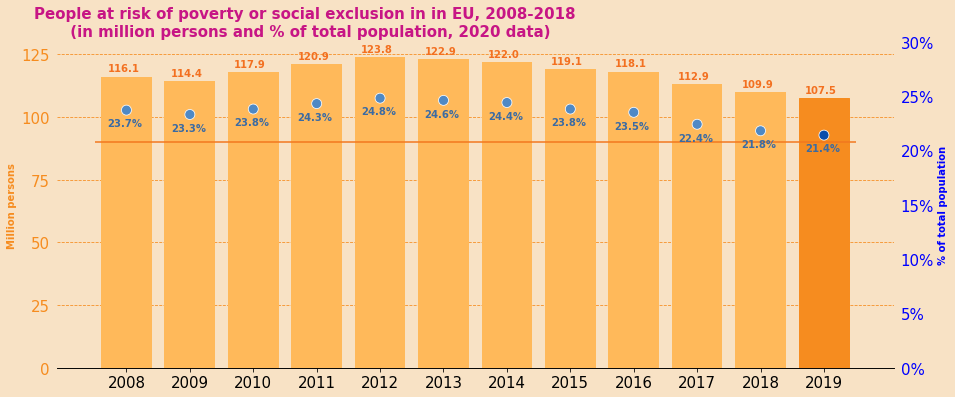

In [13]:
fig = plt.figure(facecolor='#f8e2c5', figsize = (15,6)) #We create the figure
ax = fig.add_subplot(facecolor='#f8e2c5')

barplot =ax.bar(time["ilc_peps01_ths"],values["ilc_peps01_ths"]/1000, **kw_plot["ilc_peps01_ths"]) #We draw the barplot with the first dataframe
barplot[len(df["ilc_peps01_ths"].index)-1].set_color('#f68c1f') #Highlight the 10th bar

axes1 = plt.gca() 
axes2 = axes1.twinx() #We create the secondary axis with twinx
scatterplot= sns.scatterplot(x=time["ilc_peps01_pc"], #We draw the scatterplot and specify the arguments
                             y = values["ilc_peps01_pc"],
                             hue= time["ilc_peps01_pc"],
                             ax=axes2 ,
                             **kw_plot["ilc_peps01_pc"],
                             legend = False)
# We set the ticks of both axis
axes2.set_yticks(range(0,31,5))
axes1.set_yticks(range(0,151,25))
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks =  mtick.FormatStrFormatter(fmt)
axes2.yaxis.set_major_formatter(yticks) #We set the ticks of the right axis in percentage
ax.tick_params(axis = "y", which = "both", bottom = False, top = False, left = False, right=False, colors = '#f68c1f' , labelsize = 15)
ax.tick_params(axis ='x', which = 'both', labelsize = 15)
axes2.tick_params(axis='y',right=False, colors = 'b', labelsize = 15)
ax.yaxis.label.set_color('#f68c1f')
ax.set_ylabel('Million persons', weight = 'bold')
axes2.yaxis.label.set_color('b')
axes2.set_ylabel('% of total population' , weight = 'bold')
ax.set_axisbelow(True)

ax.hlines(values["ilc_peps01_ths"][10]/1000-20,-0.5,len(df["ilc_peps01_ths"].index)-0.5, colors='#f2771e') #Horizontal line with the last value minus 20 million

# set the values in the graph with the function defined above
ax = setvaluegraph(round(values["ilc_peps01_ths"]/1000,1),ax,False,0.3,-2,10,color='#f37020',weight='bold')
axes2 = setvaluegraph(values["ilc_peps01_pc"],axes2,False,0.3,1.5,10,color='#3b6ba3',weight = 'bold', form ='{:.1f}%' )

ax.grid(True, which = 'major', axis = 'y' , color ='#f68c1f', linestyle = '--' )
sns.despine(top=True, right=True, left=True, bottom=False)

ax.set_title('People at risk of poverty or social exclusion in in EU, 2008-2018 \n (in million persons and % of total population, 2020 data)',
             fontsize=15,fontweight='bold',y=1, x=0.3, c = 'mediumvioletred');

### Figure 2: People at risk of poverty or social exclusion by socio-economic characteristic, 2018

This figure is based on the following sources: table [_ilc_peps01_](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en), and datasets [_ilc_peps02_](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps02&lang=en)
 and [_ilc_peps04_](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps04&lang=en).

#### Parameters setting

In [14]:
params_graph2 = {'ilc_peps01_sex': {'sex': ['F','M'],
                                  'geo': 'EU',
                                  'unit': 'PC',
                                  'time' : '2018',
                                  'age': 'Y_GE18',
                                  'precision' : 1},
                 'ilc_peps01_age': {'sex': 'T',
                                  'geo': 'EU',
                                  'unit': 'PC',
                                  'time' : '2018',
                                  'age': ['Y18-24','Y25-49','Y50-64','Y_GE65','Y_LT18'],
                                  'precision' : 1},
                 'hlth_dpe010_lim': {'sex': 'T',
                                     'geo': 'EU',
                                     'unit': 'PC',
                                     'time' : '2018',
                                     'age' : 'Y_GE16',
                                     'lev_limit' : ['SEV','SOME','NONE'],
                                     'precision' : 1},
                 'ilc_peps02_activ': {'sex': 'T',
                                     'geo': 'EU',
                                     'unit': 'PC',
                                     'time' : '2018',
                                     'age' : 'Y_GE18',
                                     'wstatus': ['UNE','INAC_OTH','RET','EMP'],
                                     'precision' : 1},
                 'ilc_peps04_edu' : {'sex': 'T',
                                     'geo': 'EU',
                                     'unit': 'PC',
                                     'time' : '2018',
                                     'age' : 'Y_GE18',
                                     'isced11': ['ED0-2','ED3_4','ED5-8'],
                                     'precision' : 1}
                }
params.update(params_graph2)

Using the _Eurostat_ API we extract the data from the tables with the selected parameter. Then we get the values that would be plotted in the graph sorted. 

In [15]:
dataframes_2 = ('ilc_peps01_sex','ilc_peps01_age', 'hlth_dpe010_lim','ilc_peps02_activ','ilc_peps04_edu' )
               
[df.update({ds: client.get_dataset(table[ds], params = params[ds]).to_dataframe()})
 for ds in dataframes_2]
values,time = dict.fromkeys(ds),dict.fromkeys(ds)
for ds in dataframes_2:
    values[ds] = df[ds]['values'].sort_values(ascending = False)

We set the parameters of the barplots for each dataframe used

In [16]:
kw_plot_fig2 ={'ilc_peps01_sex' : {'color' : ['orange','lightsteelblue'],
                                    'width' : 0.4},
                'ilc_peps01_age' : {'color' : ['saddlebrown','peru','lightsalmon', 'sandybrown','peachpuff'],
                                    'width' : 0.4},
                'hlth_dpe010_lim' : {'color' : ['dimgray','darkgray','lightgray'],
                                    'width' : 0.4},
                'ilc_peps04_edu' : {'color' : ['royalblue','cornflowerblue','lightsteelblue'],
                                    'width' : 0.4},
                'ilc_peps02_activ' : {'color' : ['olive','gold','khaki','lemonchiffon'],
                                    'width' : 0.4}
                
    }
kw_plot.update(kw_plot_fig2)

#### Data plot

We create a figure and and axis where the 5 barplots will be set. 

The layout elements are added or deleted such as grid, colors, ticks, title and axis title. In order to differentiate the barplots a different background color is used. 

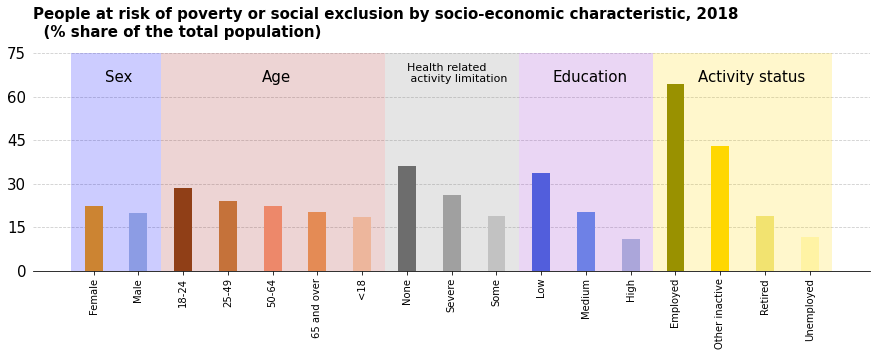

In [17]:
fig, ax = plt.subplots(figsize=(15, 4))
#Plot the bars with the 5 dataframes and set colors
bar_sex = (plt.bar(df['ilc_peps01_sex']['sex']
                   .replace(to_replace = ['F','M'], 
                            value = ['Female','Male'] ), 
                   values['ilc_peps01_sex'], 
                   **kw_plot['ilc_peps01_sex'])
          )
bar_age = (plt.bar(df['ilc_peps01_age']['age']
                   .replace(to_replace = ['Y18-24','Y_LT18','Y50-64','Y25-49','Y_GE65'],
                            value = ['18-24','<18','50-64','25-49','65 and over']),
                   values['ilc_peps01_age'], 
                   **kw_plot['ilc_peps01_age'])
          )
bar_lim = (plt.bar(df['hlth_dpe010_lim']['lev_limit']
                   .replace(to_replace = ['SEV','SOME','NONE'], 
                            value = ['Severe','Some', 'None']),
                   values['hlth_dpe010_lim'], 
                   **kw_plot['hlth_dpe010_lim'])
          )
bar_education = (plt.bar(df['ilc_peps04_edu']['isced11']
                         .replace(to_replace = ['ED0-2','ED3_4','ED5-8'],
                                  value = ['Low','Medium','High']),
                         values['ilc_peps04_edu'], 
                         **kw_plot['ilc_peps04_edu'])
                )
bar_activity = (plt.bar(df['ilc_peps02_activ']['wstatus']
                        .replace(to_replace = ['UNE','INAC_OTH','RET','EMP'], 
                                 value = ['Unemployed','Other inactive','Retired','Employed']),
                        values['ilc_peps02_activ'], 
                        **kw_plot['ilc_peps02_activ'])
               )

ax.set_yticks(range(0,76,15))
ax.tick_params(axis = "y", labelsize = 15, left = False)
sns.despine(top=True, right=True, left=True, bottom=False) #Function that allows to erase the spine
ax.grid(**grid_properties)
ax.set_axisbelow(True) #Function to set the grid below the bars
plt.xticks(rotation= 90)

ax.set_title('People at risk of poverty or social exclusion by socio-economic characteristic, 2018 \n  (% share of the total population)' 
             , title_properties)

#Set the background color for each group of indicators and text
plt.axvspan(-.5, 1+.5, facecolor='b', alpha=0.2)
plt.axvspan(1.5,6.5, facecolor='brown', alpha=0.2)
plt.axvspan(6.5,9.5, facecolor='grey', alpha=0.2)
plt.axvspan(9.5,12.5, facecolor='darkorchid', alpha=0.2)
plt.axvspan(12.5, 16.5, facecolor='gold', alpha=0.2)
plt.text( 0.25,65,'Sex', fontsize=15)
plt.text(3.75,65,'Age', fontsize=15)
plt.text(7,65,'Health related \n activity limitation', fontsize=11)
plt.text( 10.25,65,'Education', fontsize=15)
plt.text( 13.5,65,'Activity status', fontsize=15);

### Figure 3: People at risk of poverty or social exclusion by degree of urbanisation, 2018

Actual data sources used for this figure are [ilc_peps01](https://appsso.eurostat.ec.europa.eu/nui/show.do?query=BOOKMARK_DS-127829_QID_109B0E0E_UID_-3F171EB0&layout=TIME,C,X,0;GEO,L,Y,0;UNIT,L,Z,0;AGE,L,Z,1;SEX,L,Z,2;INDICATORS,C,Z,3;&zSelection=DS-127829UNIT,PC;DS-127829AGE,Y16-29;DS-127829SEX,T;DS-127829INDICATORS,OBS_FLAG;&rankName1=UNIT_1_2_-1_2&rankName2=AGE_1_2_-1_2&rankName3=INDICATORS_1_2_-1_2&rankName4=SEX_1_2_-1_2&rankName5=TIME_1_0_0_0&rankName6=GEO_1_2_0_1&sortC=ASC_-1_FIRST&rStp=&cStp=&rDCh=&cDCh=&rDM=true&cDM=true&footnes=false&empty=false&wai=false&time_mode=ROLLING&time_most_recent=false&lang=EN&cfo=%23%23%23,%23%23%23.%23%23%23&lang=en) and [ilc_peps13](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_peps13&lang=en). 

#### Parameters setting

In [18]:
params_graph3 = {'ilc_peps01_df3' :{'sex': 'T',
                                    'geo' : countries_names,
                                    'unit': 'PC',
                                    'time' : ['2018','2017','2016'],
                                    'age': 'TOTAL',
                                    'precision' : 1},
                 'ilc_peps13_urb' : {'deg_urb': ['DEG1','DEG2','DEG3'],  
                                     'unit': 'PC',
                                     'geo' : countries_names,
                                     'time' : ['2018','2017','2016']
                                     }
                 }
params.update(params_graph3)

Once selected the desired parameteres we extract the data through _Eurostat_ API:

In [19]:
dataframes_3 = ('ilc_peps01_df3','ilc_peps13_urb')

[df.update({ds: client.get_dataset(table[ds], params = params[ds]).to_dataframe()})
 for ds in dataframes_3];

We select the year and filter data by that year:

In [20]:
currentyear = '2018'

for ds in dataframes_3:
    values[ds] = df[ds][df[ds].time == currentyear].copy()

Using the function `lastyearvalue`, we check if there is missing data for the current year and replace by the most recent existing one:

In [21]:
values['ilc_peps01_df3']['values'] = lastyearvalue(values['ilc_peps01_df3'], 'values', 
                                                   df['ilc_peps01_df3'], currentyear, 'age')
values['ilc_peps13_urb']['values'] = lastyearvalue(values['ilc_peps13_urb'], 'values',  
                                                   df['ilc_peps13_urb'], currentyear, 'deg_urb')

The data of  MT  is from  2018


Using the function `EuOrderByStatuts` we sort the data to plot in that order:

In [22]:
for ds in dataframes_3:
    values[ds]['order'] = EUorderbystatus(values[ds])
    values[ds].sort_values(['order','values'], ascending = [True,False], inplace=True)

#### Data plotting 

We create a figure and and axis where the 4 scatterplots will be set. 
The background color is changed to show the different status of countries in European region
The legend is created using custom objects created with lines and patches. 

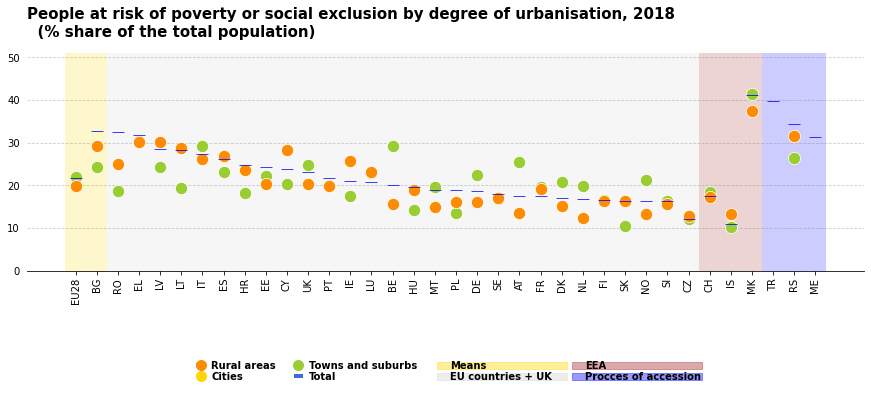

In [23]:
ig, ax = plt.subplots(figsize=(15, 4))

plt.ylim(0,51)

scatterplot = sns.scatterplot(x=values['ilc_peps01_df3'].geo, #We draw the scatterplot and specify the arguments
                             y = values['ilc_peps01_df3']['values' ],
                             s = 150 ,
                             ax = ax,
                             legend = False,
                             marker ="_",
                             color = 'b',
                             zorder = 4)
color = ['gold','yellowgreen','darkorange']

# for loop to plot one scatter for each of the deg_urb categories
for i, col in enumerate(color):
    sns.scatterplot(x=values['ilc_peps13_urb'].geo[values['ilc_peps13_urb'].deg_urb == 'DEG'+str(i)], #We draw the scatterplot and specify the arguments
                             y = values['ilc_peps13_urb']['values' ][values['ilc_peps13_urb'].deg_urb == 'DEG'+str(i)],
                             s = 150 ,       
                             legend = False,
                             color = col,
                             zorder = i + 1)

#for point in values['ilc_peps01_df3']['geo']:
    #plt.vlines(values['ilc_peps01_df3']['geo'], min(values['ilc_peps01_df3'][values['ilc_peps13_urb'].geo == point]), max(values['ilc_peps01_df3'][values['ilc_peps13_urb'].geo == point]), lw = 0.3, color = 'gray', zorder = 0, ls = '--')

sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.tick_params(axis = "x", rotation = 90)
ax.grid(**grid_properties)

ax.set_ylabel('')
ax.set_xlabel('')

# set the background color for each group of countries
plt.axvspan(-0.5,1.5, facecolor='gold', alpha=0.2)
plt.axvspan(1.5,29.5,facecolor='lightgray', alpha=0.2)
plt.axvspan(29.5,32.5, facecolor='brown', alpha=0.2)
plt.axvspan(32.5, 35.5, facecolor='b', alpha=0.2)

# create the legend with Lines and Patches
gold_point = Line2D([0], [0],lw = 4, color = 'gold', label='Cities', marker = 'o', markersize=10)
blue_line =Line2D([0], [0],lw = 4,color='royalblue', label='Total')
orange_point =Line2D([0], [0],lw = 4,color='darkorange', label='Rural areas', marker = 'o', markersize=10)
green_point = Line2D([0], [0],lw = 4,color='yellowgreen', label='Towns and suburbs', marker = 'o', markersize=10)
gold_patch = mpatches.Patch(color='gold', label='Means')
blue_patch = mpatches.Patch(color='b', label='Procces of accession')
grey_patch = mpatches.Patch(color='lightgray', label='EU countries + UK')
brown_patch = mpatches.Patch(color='brown', label='EEA')

leg = ax.legend(handles=[orange_point, gold_point, green_point,blue_line, gold_patch, grey_patch, brown_patch, blue_patch],
                frameon = False, loc = (0.20, -0.53), ncol = 4, prop = legend_properties,
                labelspacing = 0.1, handlelength = 0.5)

for patch in leg.get_patches():
    patch.set_width(130)
    patch.set_alpha(0.4)
ax.set_title('People at risk of poverty or social exclusion by degree of urbanisation, 2018 \n  (% share of the total population)' 
             , title_properties);

### Figure 5: People at risk of poverty or social exclusion by type of risk, 2018

The data source considered to plot this figure are [ilc_li02](http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02) and [ilc_pees01](http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_pees01).

#### Parameter settings

In [24]:
params_graph5 =   {'ilc_li02_total' :{'sex': 'T',
                                    'geo' : 'EU',
                                    'unit': 'PC',
                                    'sinceTimePeriod' : '2008',
                                    'age': 'TOTAL',
                                    'indic_il': 'LI_R_MD60',
                                    'precision' : 1},
                 'ilc_lvhl11_lowork' : {'sex': 'T',  
                                     'unit': 'PC_Y_LT60',
                                     'geo' : 'EU',
                                     'sinceTimePeriod' : '2008',
                                     'age' : 'Y_LT60'
                                     },
                 'ilc_mddd11_material' : {'sex': 'T',
                                          'geo' : 'EU',
                                          'unit': 'PC',
                                          'sinceTimePeriod' : '2008',
                                          'age': 'TOTAL',
                                          'precision' : 1}
                 
                 }
params.update(params_graph5)

Once selected the desired parameteres we extract the data through _Eurostat_ API. 

In [25]:
dataframes_5 = ('ilc_li02_total','ilc_lvhl11_lowork','ilc_mddd11_material')

[df.update({ds: client.get_dataset(table[ds], params = params[ds]).to_dataframe()})
 for ds in dataframes_5];

#### Data plot

We set the parameters of the plot and of the objects in the legend for each dataframe

In [26]:
kw_plot_fig5 = {'ilc_li02_total' : { 'color' : 'orange',
                                    'marker' : 'o',
                                    'ls' : 'solid'},
                'ilc_lvhl11_lowork' : { 'color' : 'royalblue',
                                       'marker' : 'o',
                                    'ls' : 'solid'},
                'ilc_mddd11_material' : { 'color' : 'darkorange',
                                          'marker' : 'o',
                                    'ls' : 'solid'}
                                          }
kw_plot.update(kw_plot_fig5)

In [27]:
kw_legend_fig5 =  {'ilc_li02_total' : { 'color' : 'orange',
                                    'marker' : 'o',
                                    'lw' : 4,
                                    'label' : 'At-risk-of-poverty rate'                                   },
                'ilc_lvhl11_lowork' : { 'color' : 'royalblue',
                                       'marker' : 'o',
                                       'lw' : 4,
                                       'label' : 'People living in household with very low work intensity'},
                'ilc_mddd11_material' : { 'color' : 'darkorange',
                                          'marker' : 'o',
                                    'lw' : 4,
                                    'label' : 'Severe material deprivation rate'}
                                          }
kw_legend.update(kw_legend_fig5)

We create a figure where lines are plotted iterating from the values extracted for each dataframe

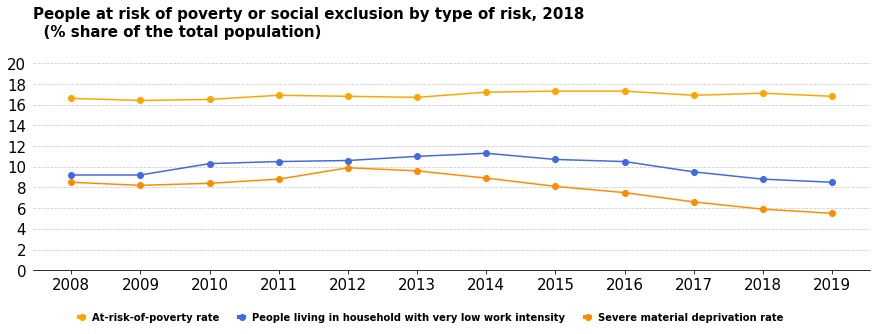

In [28]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.style.use('default') # Set the aesthetic style of the plots

plt.ylim(0,21)
plt.yticks(np.arange(0, 21, step=2))
legend = dict.fromkeys(ds,{})
for ds in dataframes_5:
    data = df[ds].copy()
    values[ds] = data['values']
    time[ds] = data['time']
    plt.plot(time[ds],values[ds],**kw_plot[ds])
    legend[ds]= Line2D([0], [0], **kw_legend[ds])
ax.grid(**grid_properties)
sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = 'both',which = 'major' , labelsize = 15)
ax.tick_params(axis = "y", left = False)

leg= ax.legend(handles=[legend['ilc_li02_total'],legend['ilc_lvhl11_lowork'], legend['ilc_mddd11_material']],frameon=False, loc=(0.05, -.26), ncol=3, prop=legend_properties,labelspacing=0.1, handlelength=0.5)
ax.set_title('People at risk of poverty or social exclusion by type of risk, 2018 \n  (% share of the total population)' 
             ,title_properties);

### Figure 6: At-risk-of-poverty rate and at-risk-of-poverty threshold, 2018 

Actual data sources are [ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en) and [ilc_li01](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li01&lang=en).

#### Set parameters for the different datasets

In [29]:
params_graph6 = { 'ilc_li02_rate' : {'sex': 'T',
                                    'geo' : countries_names,
                                    'unit': 'PC',
                                    'time' : ['2018','2017','2016'],
                                    'age': 'TOTAL',
                                    'indic_il': 'LI_R_MD60',
                                    'precision' : 1},
                 'ilc_li01_treshold' : {'sex': 'T',
                                        'geo' : countries_names,
                                        'unit': 'PC',
                                        'time' : ['2018','2017','2016'],
                                        'indic_il': 'LI_C_M60',
                                        'currency' : 'EUR',
                                        'hhtyp' : 'A1',
                                        'precision' : 1}}
params.update(params_graph6)

Once selected the desired parameteres we extract the data with the Eurostat API:

In [30]:
dataframes_6 = ['ilc_li02_rate','ilc_li01_treshold']

[df.update({ds: client.get_dataset(table[ds], params = params[ds]).to_dataframe()})
 for ds in dataframes_6];

We filter data by the current year:

In [31]:
currentyear = '2018'

for ds in dataframes_6:
    values[ds] = df[ds][df[ds].time == currentyear].copy()

Using the function `lastyearvalue`, we fetch if there is missing data for the current year and replace by the most recent existing one. The values from the threshold dataframe must be divided by 1000 to fit the PPS:

In [32]:
values['ilc_li02_rate']['values'] = lastyearvalue(values['ilc_li02_rate'], 'values',  
                                                  df['ilc_li02_rate'], currentyear, 'age')
values['ilc_li01_treshold']['values'] = lastyearvalue(values['ilc_li01_treshold'], 'values', 
                                            df['ilc_li01_treshold'], currentyear, 'currency')

values['ilc_li01_treshold']['values'] = values['ilc_li01_treshold']['values'] / 1000

Using function `EuOrderByStatuts` we sort the data to plot in that order.
It is not necessary to order both dataframes since the second plot will be plotted over the index of the first one

In [33]:
values['ilc_li02_rate']['order'] = EUorderbystatus(values['ilc_li02_rate'])
values['ilc_li02_rate'].sort_values(['order','values'], ascending = [True,False], inplace = True)

#### Parameters setting

We set the parameters of the plot and of the objects in the legend for each dataframe

In [34]:
kw_plot_fig6 = {'ilc_li02_rate' : {'color': 'gold' ,
                                   's' : 150,
                                   'legend': False,
                                   'zorder': 1},
                'ilc_li01_treshold' : {'color': 'royalblue' ,
                                       's' : 150,
                                       'legend': False,
                                       'zorder': 4}
    }
kw_plot.update(kw_plot_fig6)

In [35]:
kw_legend_fig6 = {'ilc_li02_rate': {'lw' : 4,
                                    'color' : 'gold',
                                    'label' : 'At-risk-of-poverty rate',
                                    'marker' : 'o',
                                    'markersize' : 10},
                  'ilc_li01_treshold' : {'lw' : 4,
                                         'color' : 'royalblue',
                                         'label' : 'At-risk-of-poverty treshold for single person',
                                         'marker' : 'o',
                                         'markersize' : 10}
                  }
kw_legend.update(kw_legend_fig6)

#### Data plot

We create a figure where the 2 bubble plots will be set. The layout part and legend are fit to the properties selected above:

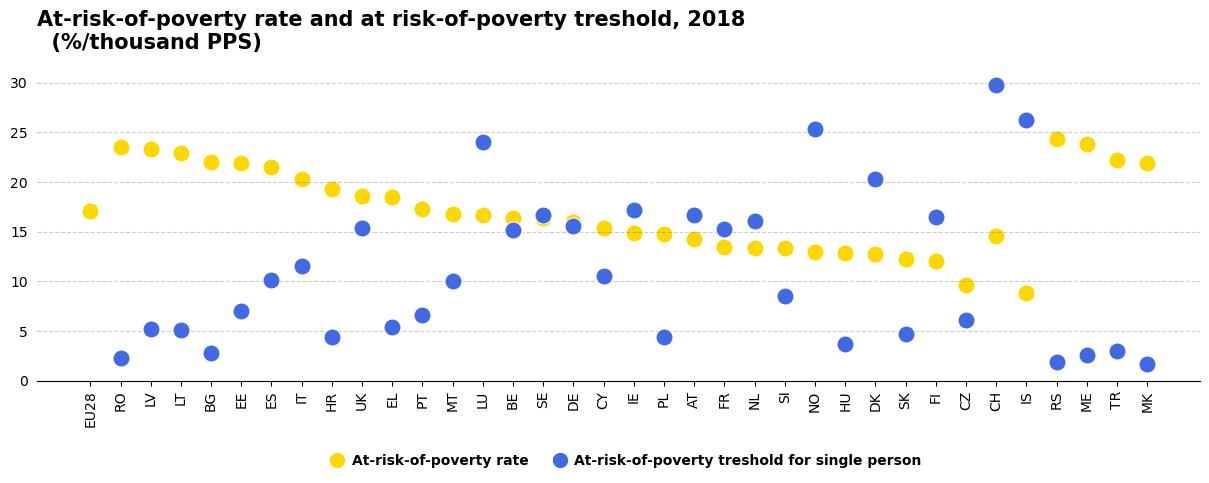

In [36]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.ylim(0,31)

for ds in dataframes_6:
    sns.scatterplot(x=values[ds].geo,
                    y = values[ds]['values'],
                    **kw_plot[ds])
    legend[ds]= Line2D([0], [0], **kw_legend[ds])
    
    
sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.tick_params(axis = "x", rotation = 90)

ax.grid(**grid_properties)

ax.set_ylabel('')
ax.set_xlabel('')


leg= ax.legend(handles=[legend['ilc_li02_rate'], legend['ilc_li01_treshold']],frameon=False, loc=(0.25, -0.30), ncol=2, prop=legend_properties,labelspacing=0.1, handlelength=0.5)
ax.set_title('At-risk-of-poverty rate and at risk-of-poverty treshold, 2018 \n  (%/thousand PPS)' 
             , title_properties);

### Figure 7: At-risk-of-poverty rate - before and after - deducting housing costs, 2018

Data sources for this figure are: [ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en) and [ilc_li48](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li48&lang=en).

#### Parameters setting

In [37]:
params_graph7 = { 'ilc_li02_bef' : {'sex': 'T',
                                    'geo' : countries_names,
                                    'unit': 'PC',
                                    'time' : ['2018','2017','2016'],
                                    'age': 'TOTAL',
                                    'indic_il': 'LI_R_MD60',
                                    'precision' : 1},
                 'ilc_li48_aft' : {'deg_urb' : 'TOTAL',
                                   'geo' : countries_names,
                                   'time' : ['2018','2017','2016'],
                                   'precision': 1}
                 }
params.update(params_graph7)


Once selected the desired parameteres we extract the data with the Eurostat API:

In [38]:
dataframes_7 = ('ilc_li02_bef','ilc_li48_aft')

[df.update({ds: client.get_dataset(table[ds], params = params[ds]).to_dataframe()})
 for ds in dataframes_7];

We filter data by the current year:

In [39]:
currentyear = '2018'

for ds in dataframes_7:
    values[ds] = df[ds][df[ds].time == currentyear].copy()

We check if there is missing data for the current year and replace by the most recent existing one:

In [40]:
values['ilc_li02_bef']['values'] = lastyearvalue(values['ilc_li02_bef'],'values',
                                       df['ilc_li02_bef'],currentyear,'age')
values['ilc_li48_aft']['values'] = lastyearvalue(values['ilc_li48_aft'], 'values', 
                                       df['ilc_li48_aft'], currentyear, 'deg_urb')

We sort the data to plot in that order using `EuOrderByStatuts`. 
It is not necessary to order both dataframes since the second plot will be plotted over the index of the first one:

In [41]:
values['ilc_li02_bef']['order'] = EUorderbystatus(values['ilc_li02_bef'])

values['ilc_li02_bef'].sort_values(['order','values'], ascending = [True,False], inplace = True)

We set the parameters of the plot and of the objects in the legend for each dataframe:

In [42]:
kw_plot_fig7 = {'ilc_li02_bef' : {'color' : 'orange'},
                'ilc_li48_aft' : {'color' : 'royalblue'}}
kw_plot.update(kw_plot_fig7)

In [43]:
kw_legend_fig7 = {'ilc_li02_bef' : {'color' : 'orange',
                                    'label':'Before deducting housing costs'},
                  'ilc_li48_aft' : {'color' : 'royalblue',
                                    'label':'After deducting housing costs'}
                  }
kw_legend.update(kw_legend_fig7)

#### Data plot

We create a figure and and axis where the 2 barplots will be set. A `width` variable is created so that adding on one barplot and resting on the other barplot will plot the two bars one next to the other.
The index of the dataframe is changed to geographical position and the values are merged by the index.
Finally the layout part and legend are done with the selected properties:

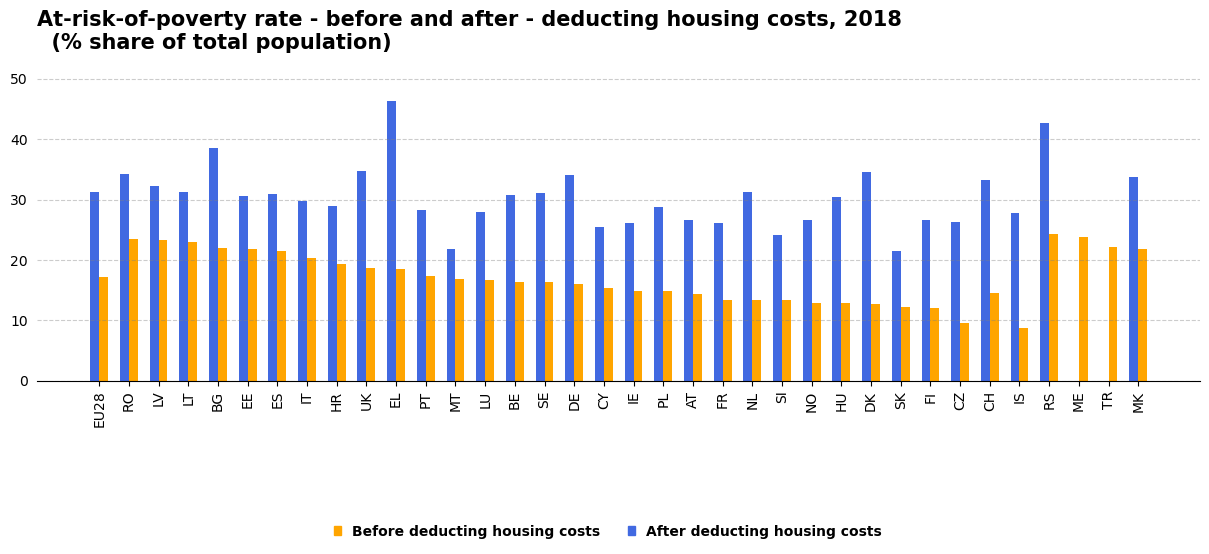

In [44]:
fig, ax = plt.subplots(figsize=(15, 4))

for ds in dataframes_7:
    values[ds].set_index('geo', inplace = True)
    legend[ds] = mpatches.Patch(**kw_legend[ds])

merged7 = values['ilc_li02_bef'].join(values['ilc_li48_aft']['values'],rsuffix = '_aft')
labels7 = merged7.index.values.tolist()
x = np.arange(len(merged7))

plt.ylim(0,51)

width = 0.3 #Use width to create 2 bar charts in the same axis one next to the other

ax.bar(x+width/2, merged7['values'],width, **kw_plot['ilc_li02_bef'])
ax.bar( x-width/2,merged7['values_aft'],width, **kw_plot['ilc_li48_aft'])
plt.xticks(x)

ax.set_xticklabels(labels7, rotation = 90) #Set the labels of the x axis as the countries

sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.grid(**grid_properties, zorder = 0)

    
leg= ax.legend(handles=[legend['ilc_li02_bef'], legend['ilc_li48_aft']],frameon=False, loc=(0.25, -0.53), ncol=2, prop=legend_properties,labelspacing=0.1, handlelength=0.5)

ax.set_title('At-risk-of-poverty rate - before and after - deducting housing costs, 2018 \n  (% share of total population)' 
             , title_properties);

### Figure 8: At-risk-of-poverty rate - before and after - social transfers, 2018

Source data for this figure are [ilc_li02](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li02&lang=en) and [ilc_li10](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li10&lang=en).

#### Parameters setting

In [45]:
params_graph8 = { 'ilc_li02_aft' : {'sex': 'T',
                                    'geo' : countries_names,
                                    'time' : ['2018','2017','2016'],
                                    'age': 'TOTAL',
                                    'unit' : 'PC',
                                    'indic_il': 'LI_R_MD60',
                                    'precision' : 1},
                 'ilc_li10_bef' : {'age' : 'TOTAL',
                                   'sex' : 'T',
                                   'geo' : countries_names,
                                   'time' : ['2018','2017','2016'],
                                   'indic_il': 'LI_R_MD60BT',
                                   'precision': 1}
                 }
params.update(params_graph8)

Once selected the desired parameteres we extract the data with the Eurostat API:

In [46]:
dataframes_8 = ('ilc_li02_aft','ilc_li10_bef')

[df.update({ds: client.get_dataset(table[ds], params = params[ds]).to_dataframe()})
 for ds in dataframes_8];

We filter data by the current year:

In [47]:
currentyear = '2018'

for ds in dataframes_8:
    values[ds] = df[ds][df[ds].time == currentyear].copy()
    legend[ds] = mpatches.Patch(**kw_legend[ds])

We check if there is missing data for the current year and replace by the most recent existing one:

In [48]:
values['ilc_li02_aft']['values'] = lastyearvalue(values['ilc_li02_aft'],'values',
                                                 df['ilc_li02_aft'],currentyear,'age')
values['ilc_li10_bef']['values'] = lastyearvalue(values['ilc_li10_bef'], 'values', 
                                                 df['ilc_li10_bef'], currentyear, 'age')

We sort the data to plot according to the order set in the function `EuOrderByStatuts`.
Note that it is not necessary to order both dataframes since the second plot will be plotted over the index of the first one:

In [49]:
values['ilc_li02_aft']['order'] = EUorderbystatus(values['ilc_li02_aft'])

values['ilc_li02_aft'].sort_values(['order','values'],ascending = [True,False], inplace = True)

We set the parameters of the plot and of the objects in the legend for each dataframe:

In [50]:
kw_plot_fig8 = {'ilc_li10_bef' : {'color' : 'orange'},
                'ilc_li02_aft' : {'color' : 'royalblue'}}
kw_plot.update(kw_plot_fig7)

In [51]:
kw_legend_fig8 = {'ilc_li10_bef' : {'color' : 'orange',
                                    'label':'Before social transfer (but after pensions)'},
                  'ilc_li02_aft' : {'color' : 'royalblue',
                                    'label':'After social transfers'}
                  }
kw_legend.update(kw_legend_fig8)

#### Data plot 

We create a figure and and axis where the 2 barplots will be set. 
A `width` variable is created so that adding on one barplot and resting on the other barplot will plot the two bars one next to the other.
The index of the dataframe is changed to geographical position and the values are merged by the index.
Finally the layout part and legend are done with the selected properties:

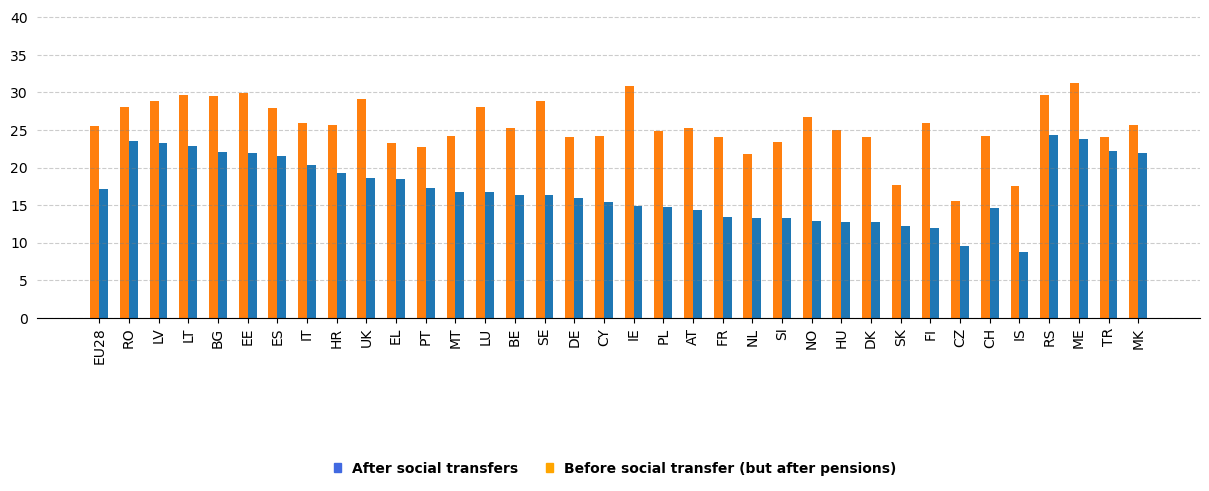

In [52]:
fig, ax = plt.subplots(figsize=(15, 4))

plt.ylim(0,41)

for ds in dataframes_8:
    values[ds].set_index('geo', inplace = True)
    legend[ds] = mpatches.Patch(**kw_legend[ds])

merged8 = values['ilc_li02_aft'].join(values['ilc_li10_bef']['values'],rsuffix = '_bef')

x = np.arange(len(merged8))
labels8 = merged8.index.values.tolist()
width = 0.3 #Use width to create 2 bar charts in the same axis one next to the other

bar_after = ax.bar(x + width/2,merged8['values'], width, **kw_plot['ilc_li02_aft'])
bar_before = ax.bar(x - width/2,merged8['values_bef'], width, **kw_plot['ilc_li10_bef'])

ax.set_xticklabels(labels8, rotation = 90) #Set the labels of the x axis as the countries

sns.despine(top=True, right=True, left=True, bottom=False)
ax.tick_params(axis = "y", left = False)
ax.grid(**grid_properties, zorder = 0)

plt.xticks(x)

leg = ax.legend(handles=[legend['ilc_li02_aft'], legend['ilc_li10_bef']],
                frameon=False, loc=(0.25, -0.53), ncol=2, 
                prop=legend_properties,labelspacing=0.1, handlelength=0.5)

### Map 1: At-risk-of-poverty rate anchored in 2008, 2008-2018 

The data sources used for this figure are [ilc_li22b](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=ilc_li22b&lang=en).

### Data retrieval

We set the current directory.

In [53]:
_HOME_ = os.environ['HOME']
_THISDIR_ = !pwd
print('Current working directory: %s' % _THISDIR_[0].split('popul/')[1])

Current working directory: popul/living-conditions


#### NUTS geometries harvesting

We first select the projection that will be used in this graph. In this case [*WGS 84 EPSG:4326*](https://spatialreference.org/ref/epsg/4326/)

In [54]:
PROJ = 'EPSG:4326'

We can then integrate the [NUTS data](https://gisco-services.ec.europa.eu/distribution/v2/nuts/)

In [55]:
GISCO_DOMAIN = 'https://gisco-services.ec.europa.eu/distribution/v2/'
NUTS_DOMAIN = 'nuts'

NUTS_YEAR = 2021
NUTS_RES = 20 # 60
NUTS_PROJ = PROJ.split(':')[-1] 
NUTS_FMT = 'geojson' # 'topojson'

nuts_template = 'NUTS_RG_%sM_%s_%s_LEVL_%%s.%s' % (NUTS_RES, NUTS_YEAR, NUTS_PROJ, NUTS_FMT) 
nuts_url = '%s/%s/%s' %  (GISCO_DOMAIN, NUTS_DOMAIN, NUTS_FMT)

print("Generic URL for NUTS data: \033[1m%s/%s\033[0m (where '%%s' represents a level)" 
      % (nuts_url, nuts_template))

Generic URL for NUTS data: https://gisco-services.ec.europa.eu/distribution/v2//nuts/geojson/NUTS_RG_20M_2021_4326_LEVL_%s.geojson (where '%s' represents a level)


We download the different NUTS data, in this case NUTS at level 1:

In [56]:
LEVELS = [0,1,2,3]

nuts_files = dict.fromkeys(LEVELS)
nuts_ext = NUTS_FMT

for level in LEVELS:
    nuts_file = nuts_template % level
    nuts_source = '%s/%s' % (nuts_url,nuts_file)
    try : 
        dest = os.path.join(_THISDIR_[0], nuts_file)
        assert os.path.exists(dest)
    except:
        try:
            !wget -O $dest "$nuts_source"
            #!mkdir $nuts_dir
            #!unzip -u -d $nuts_dir $nuts_source        
        except:
            raise IOError("Error fetching the data...")
        else:
            print('Data loaded on disk in directory: \033[1m%s\033[0m' % dest.split('popul/')[1])
    else:
        print('Data already loaded on disk in directory: \033[1m%s\033[0m' % dest.split('popul/')[1])
    finally:
        nuts_files.update({level: nuts_file}) # dest

Data already loaded on disk in directory: popul/living-conditions/NUTS_RG_20M_2021_4326_LEVL_0.geojson
Data already loaded on disk in directory: popul/living-conditions/NUTS_RG_20M_2021_4326_LEVL_1.geojson
Data already loaded on disk in directory: popul/living-conditions/NUTS_RG_20M_2021_4326_LEVL_2.geojson
Data already loaded on disk in directory: popul/living-conditions/NUTS_RG_20M_2021_4326_LEVL_3.geojson


We 'store' one vector dataset per NUTS level (nuts_data)

In [57]:
DRIVERS = {'geojson': 'GeoJSON',
          'shp': 'ESRI Shapefile'}

nuts_data = dict.fromkeys(LEVELS)
[nuts_data.update({l: gpd.read_file(os.path.join(_THISDIR_[0], nuts_files[l]), 
                                    driver=DRIVERS[NUTS_FMT])}) 
 for l in LEVELS]

print("Geographical datasets: \033[1m%s\033[0m loaded" % list(nuts_files.values()))
print("Projection: \033[1m%s\033[0m" % nuts_data[LEVELS[0]].crs)

Geographical datasets: ['NUTS_RG_20M_2021_4326_LEVL_0.geojson', 'NUTS_RG_20M_2021_4326_LEVL_1.geojson', 'NUTS_RG_20M_2021_4326_LEVL_2.geojson', 'NUTS_RG_20M_2021_4326_LEVL_3.geojson'] loaded
Projection: epsg:4326


We create a map of NUTS data:

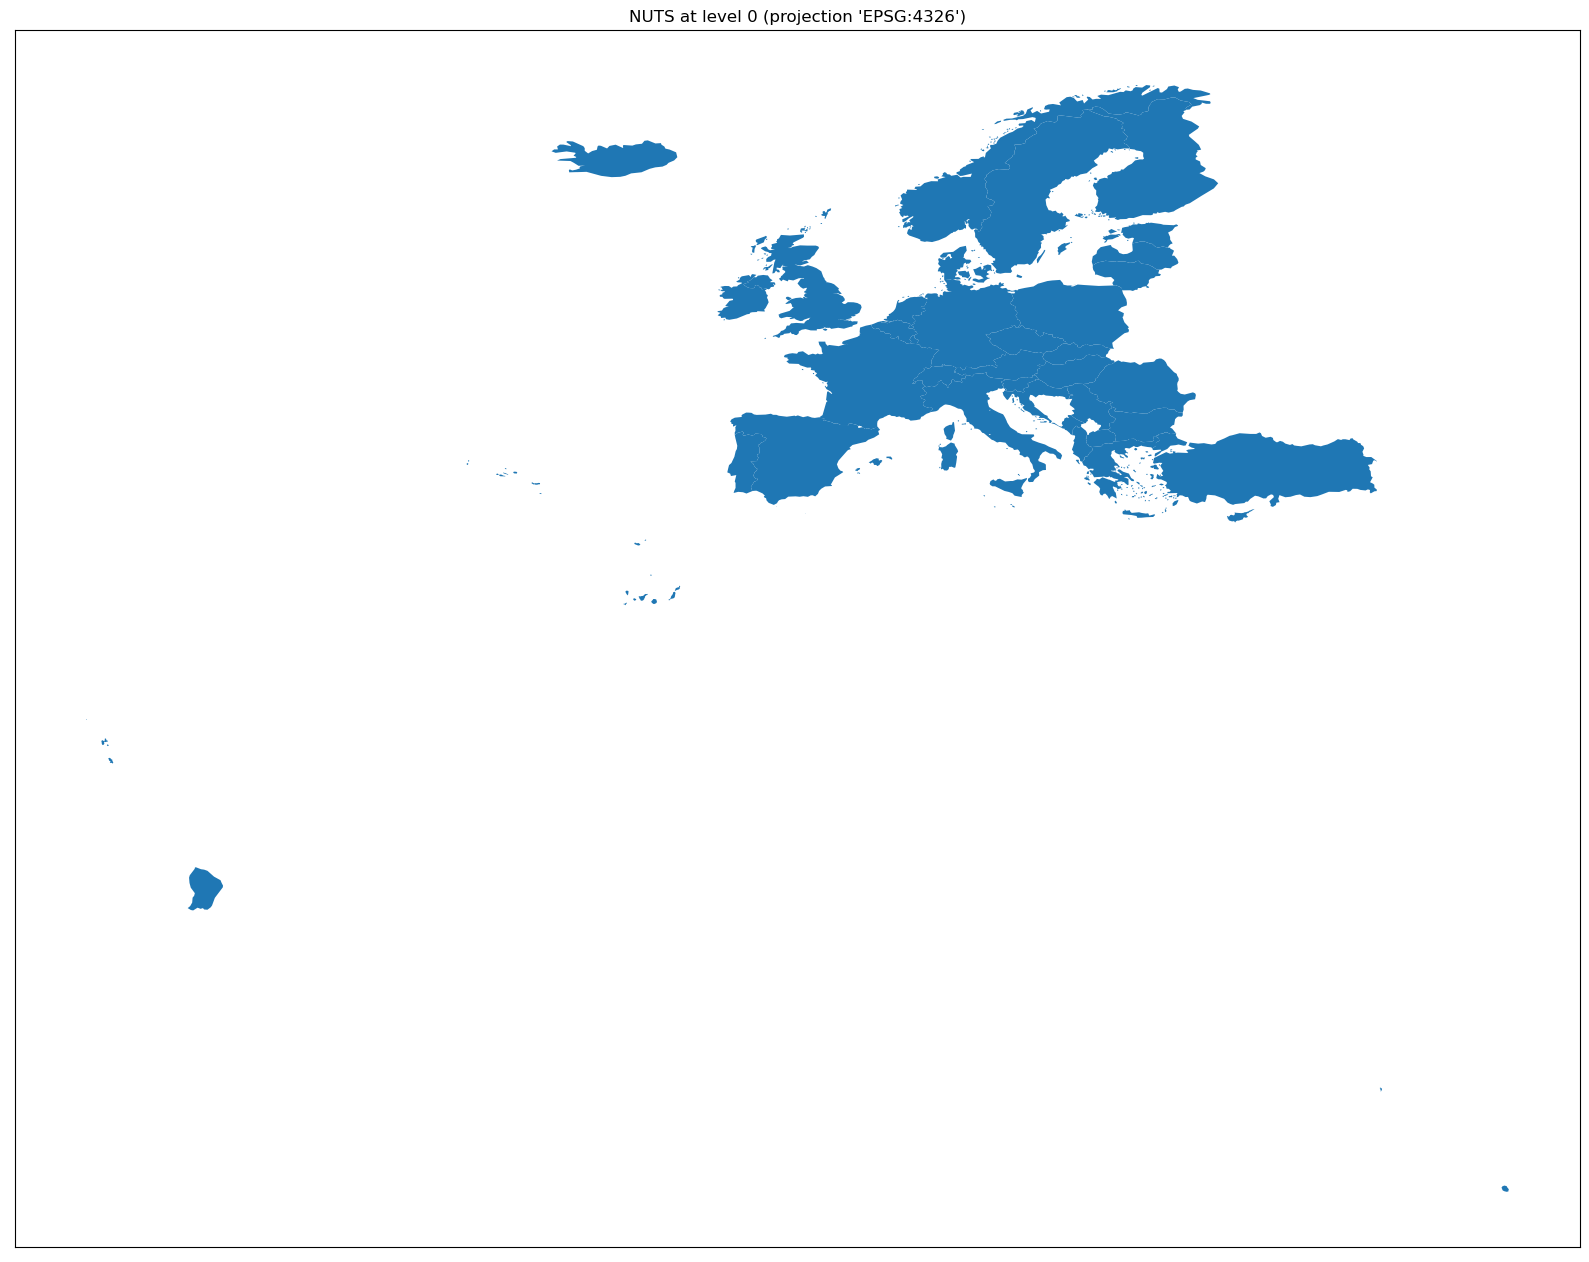

In [58]:
level = LEVELS[0]

f, ax = plt.subplots(1, figsize=(16, 16))
nuts_data[level].plot(ax=ax)
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title("NUTS at level %s (projection 'EPSG:%s')" % (level,NUTS_PROJ)) 
f.tight_layout()
plt.show()

#### Data retrieval and cleansing

First we define the parameters of the information that we want to retrieve from the _Eurostat_ tables. 
Also select the period of reference of the map:

In [59]:
currentyear = '2018'
compareyear = '2008'

params_map1 = {'ilc_li22b_map' : {'sex' : 'T',
                                'indic_il' : 'LI_R_MD60',
                                'unit' : 'PC',
                                'time' : [compareyear,currentyear],
                                'age' : 'TOTAL',
                                'precision' : 1}
              }
params.update(params_map1)
dataframe_map = 'ilc_li22b_map'

Using _Eurostat_ API we extract the data from the tables with the selected parameter. We get the values that would be plotted in the graph (`currentyear` - `compareyear`):

In [60]:
df.update({dataframe_map: client.get_dataset(table[dataframe_map], params = params[dataframe_map]).to_dataframe()})

We set the geographical index and compute the difference between the periods of study

In [61]:
valuescurrent= df[dataframe_map][df[dataframe_map].time == currentyear].set_index('geo')
valuescompare = df[dataframe_map][df[dataframe_map].time == compareyear].set_index('geo')
valuesmap = valuescurrent.join(valuescompare['values'],rsuffix = '_compare')
valuesmap['dif'] = valuesmap['values']-valuesmap['values_compare']
valuesmap.head()

,values,unit,indic_il,sex,age,time,values_compare,dif
geo,,,,,,,,
AT,11.7,PC,LI_R_MD60,T,TOTAL,2018,15.2,-3.5
BE,12.7,PC,LI_R_MD60,T,TOTAL,2018,14.7,-2.0
BG,11.3,PC,LI_R_MD60,T,TOTAL,2018,21.4,-10.1
CH,12.0,PC,LI_R_MD60,T,TOTAL,2018,15.7,-3.7
CY,25.5,PC,LI_R_MD60,T,TOTAL,2018,15.9,9.6


#### Map setting

A conditional is used in order to set to each of the ranges of values a color:

In [62]:
colors = []
for value in valuesmap['dif']:
    if value< -4.0:
        colors.append('navajowhite')
    elif value< 0.0:
        colors.append('orange')
    elif value< 4:
        colors.append('chocolate')
    elif value >4:
        colors.append('orangered')
    else:
        colors.append('darkgrey')
valuesmap['colors'] = colors
valuesmap['geo'] = valuesmap.index.tolist()

Check which data/countries (`DATA_NUTS_ID`) are actually made available throughout the dataset:

In [63]:
KEY = 'NUTS_ID'

NUTS_ID = dict.fromkeys(LEVELS)
CTRY_ID = dict.fromkeys(LEVELS) 

for l in LEVELS:
    NUTS_ID.update({l: nuts_data[l][KEY].unique().tolist()})
    CTRY_ID.update({l: list(set([_id[:2] for _id in NUTS_ID[l]]))})
    
DATA_NUTS_ID = dict.fromkeys(LEVELS) 
all_id = valuesmap.index.tolist()

print('Data are availalble:') 
for l in LEVELS:
    DATA_NUTS_ID.update({l: list(set([_id[:2] for _id in all_id if len(_id)==l+2]))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, DATA_NUTS_ID[l]))

Data are availalble:
* NUTS level 0: ['DE', 'PT', 'ES', 'EL', 'IE', 'SI', 'LV', 'LU', 'AT', 'EA', 'MT', 'PL', 'IT', 'DK', 'NO', 'NL', 'CZ', 'EE', 'UK', 'FR', 'IS', 'RO', 'SK', 'SE', 'CH', 'HU', 'BE', 'CY', 'FI', 'LT', 'TR', 'BG', 'EU']
* NUTS level 1: []
* NUTS level 2: ['EU', 'EA']
* NUTS level 3: []


 Check which country/datasets are missing:

In [64]:
MISSING_CTRY_ID = dict.fromkeys(LEVELS) 

print('Data are NOT availalble:') 
for l in LEVELS:
    MISSING_CTRY_ID.update({l: list(set(CTRY_ID[l]).difference(set(DATA_NUTS_ID[l])))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, MISSING_CTRY_ID[l]))

Data are NOT availalble:
* NUTS level 0: ['LI', 'AL', 'HR', 'ME', 'MK', 'RS']
* NUTS level 1: ['LI', 'PT', 'DE', 'ES', 'EL', 'IE', 'SI', 'LV', 'LU', 'BG', 'AT', 'PL', 'ME', 'IT', 'MK', 'DK', 'NO', 'NL', 'CZ', 'EE', 'HR', 'UK', 'FR', 'RO', 'IS', 'RS', 'SK', 'SE', 'AL', 'CH', 'HU', 'BE', 'CY', 'LT', 'FI', 'TR', 'MT']
* NUTS level 2: ['LI', 'PT', 'DE', 'ES', 'EL', 'IE', 'SI', 'LV', 'LU', 'AT', 'PL', 'MT', 'ME', 'IT', 'MK', 'DK', 'NO', 'NL', 'CZ', 'EE', 'HR', 'UK', 'FR', 'IS', 'RO', 'RS', 'SK', 'SE', 'AL', 'CH', 'HU', 'BE', 'CY', 'LT', 'FI', 'TR', 'BG']
* NUTS level 3: ['LI', 'PT', 'DE', 'ES', 'EL', 'IE', 'SI', 'LV', 'LU', 'BG', 'AT', 'PL', 'ME', 'IT', 'MK', 'DK', 'NO', 'NL', 'CZ', 'EE', 'HR', 'UK', 'FR', 'RO', 'IS', 'RS', 'SK', 'SE', 'AL', 'CH', 'HU', 'BE', 'CY', 'FI', 'LT', 'TR', 'MT']


Prepare dataframe to merge the `NUTS DATA`:

In [65]:
valuesmap.rename(columns = {'geo':'NUTS_ID'}, inplace = True)
valuesmap.head(n = 5)

,values,unit,indic_il,sex,age,time,values_compare,dif,colors,NUTS_ID
geo,,,,,,,,,,
AT,11.7,PC,LI_R_MD60,T,TOTAL,2018,15.2,-3.5,orange,AT
BE,12.7,PC,LI_R_MD60,T,TOTAL,2018,14.7,-2.0,orange,BE
BG,11.3,PC,LI_R_MD60,T,TOTAL,2018,21.4,-10.1,navajowhite,BG
CH,12.0,PC,LI_R_MD60,T,TOTAL,2018,15.7,-3.7,orange,CH
CY,25.5,PC,LI_R_MD60,T,TOTAL,2018,15.9,9.6,orangered,CY


We merge the tables `country_data` and `valuesmap`:

In [66]:
country_data = nuts_data[LEVELS[0]]

# Merge on NUTS_ID
income_nuts = pd.merge(country_data, valuesmap, how = 'inner', on = 'NUTS_ID')
income_nuts.head()
colors = income_nuts['colors']

We define a very coarse bounding box that is embedded in the NUTS bounding box (`NUTSarea`) so as to render the data in a smaller region:

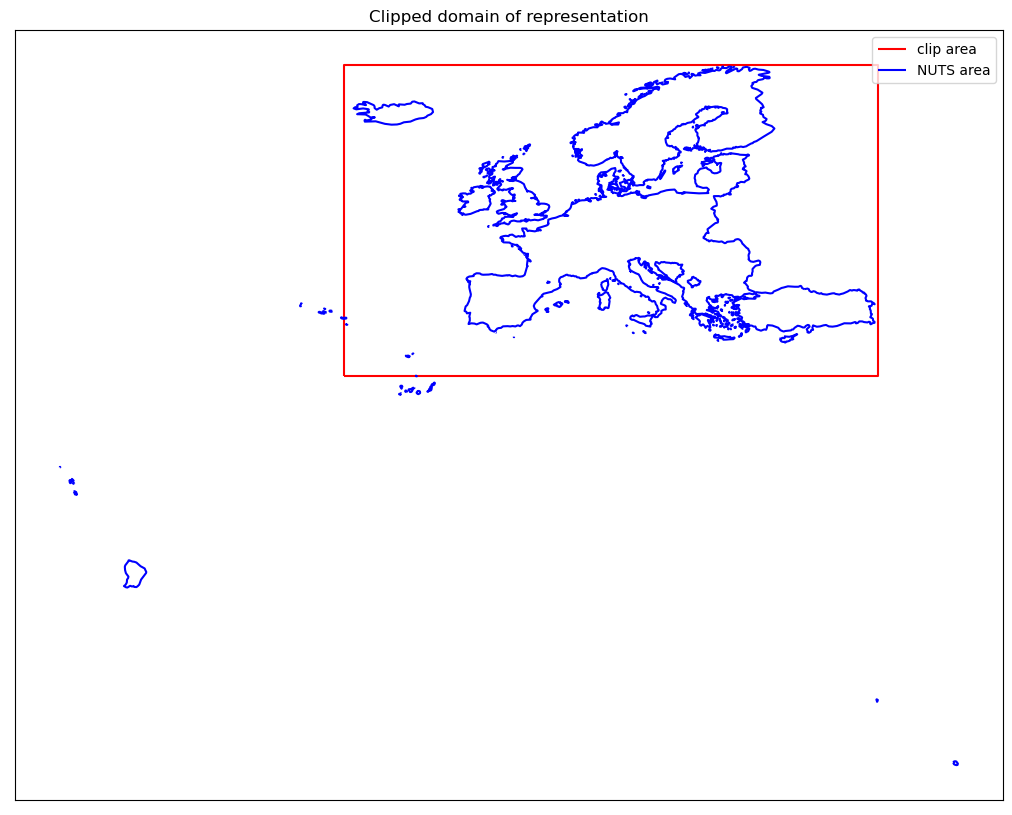

In [67]:
EUmask = geometry.Polygon([#w: -25.5, s:35, e:30.2, n:71.3 in EPSG:4326 system
                         (-25.5, 30.2),
                         (45.3,  30.2),
                         (45.3,  71.3),
                         (-25.5, 71.3)
])
EUclip = gpd.GeoDataFrame(index=[0], geometry=[EUmask], crs=PROJ)

NUTSarea = gpd.GeoDataFrame(index=[0], geometry=[nuts_data[0].unary_union], crs=PROJ)


f, ax = plt.subplots(1, figsize=(16, 10))
EUclip.boundary.plot(ax=ax, color='r', label='clip area')
NUTSarea.boundary.plot(ax=ax, color='b', label='NUTS area')
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title('Clipped domain of representation')
ax.legend()
plt.show()

#### Data plot

Using the dataframe created merging the data from _Eurostat_ and the NUTS, the map is represented with appropriate colors. 
The boundaries are highlihted in black in the map representation.

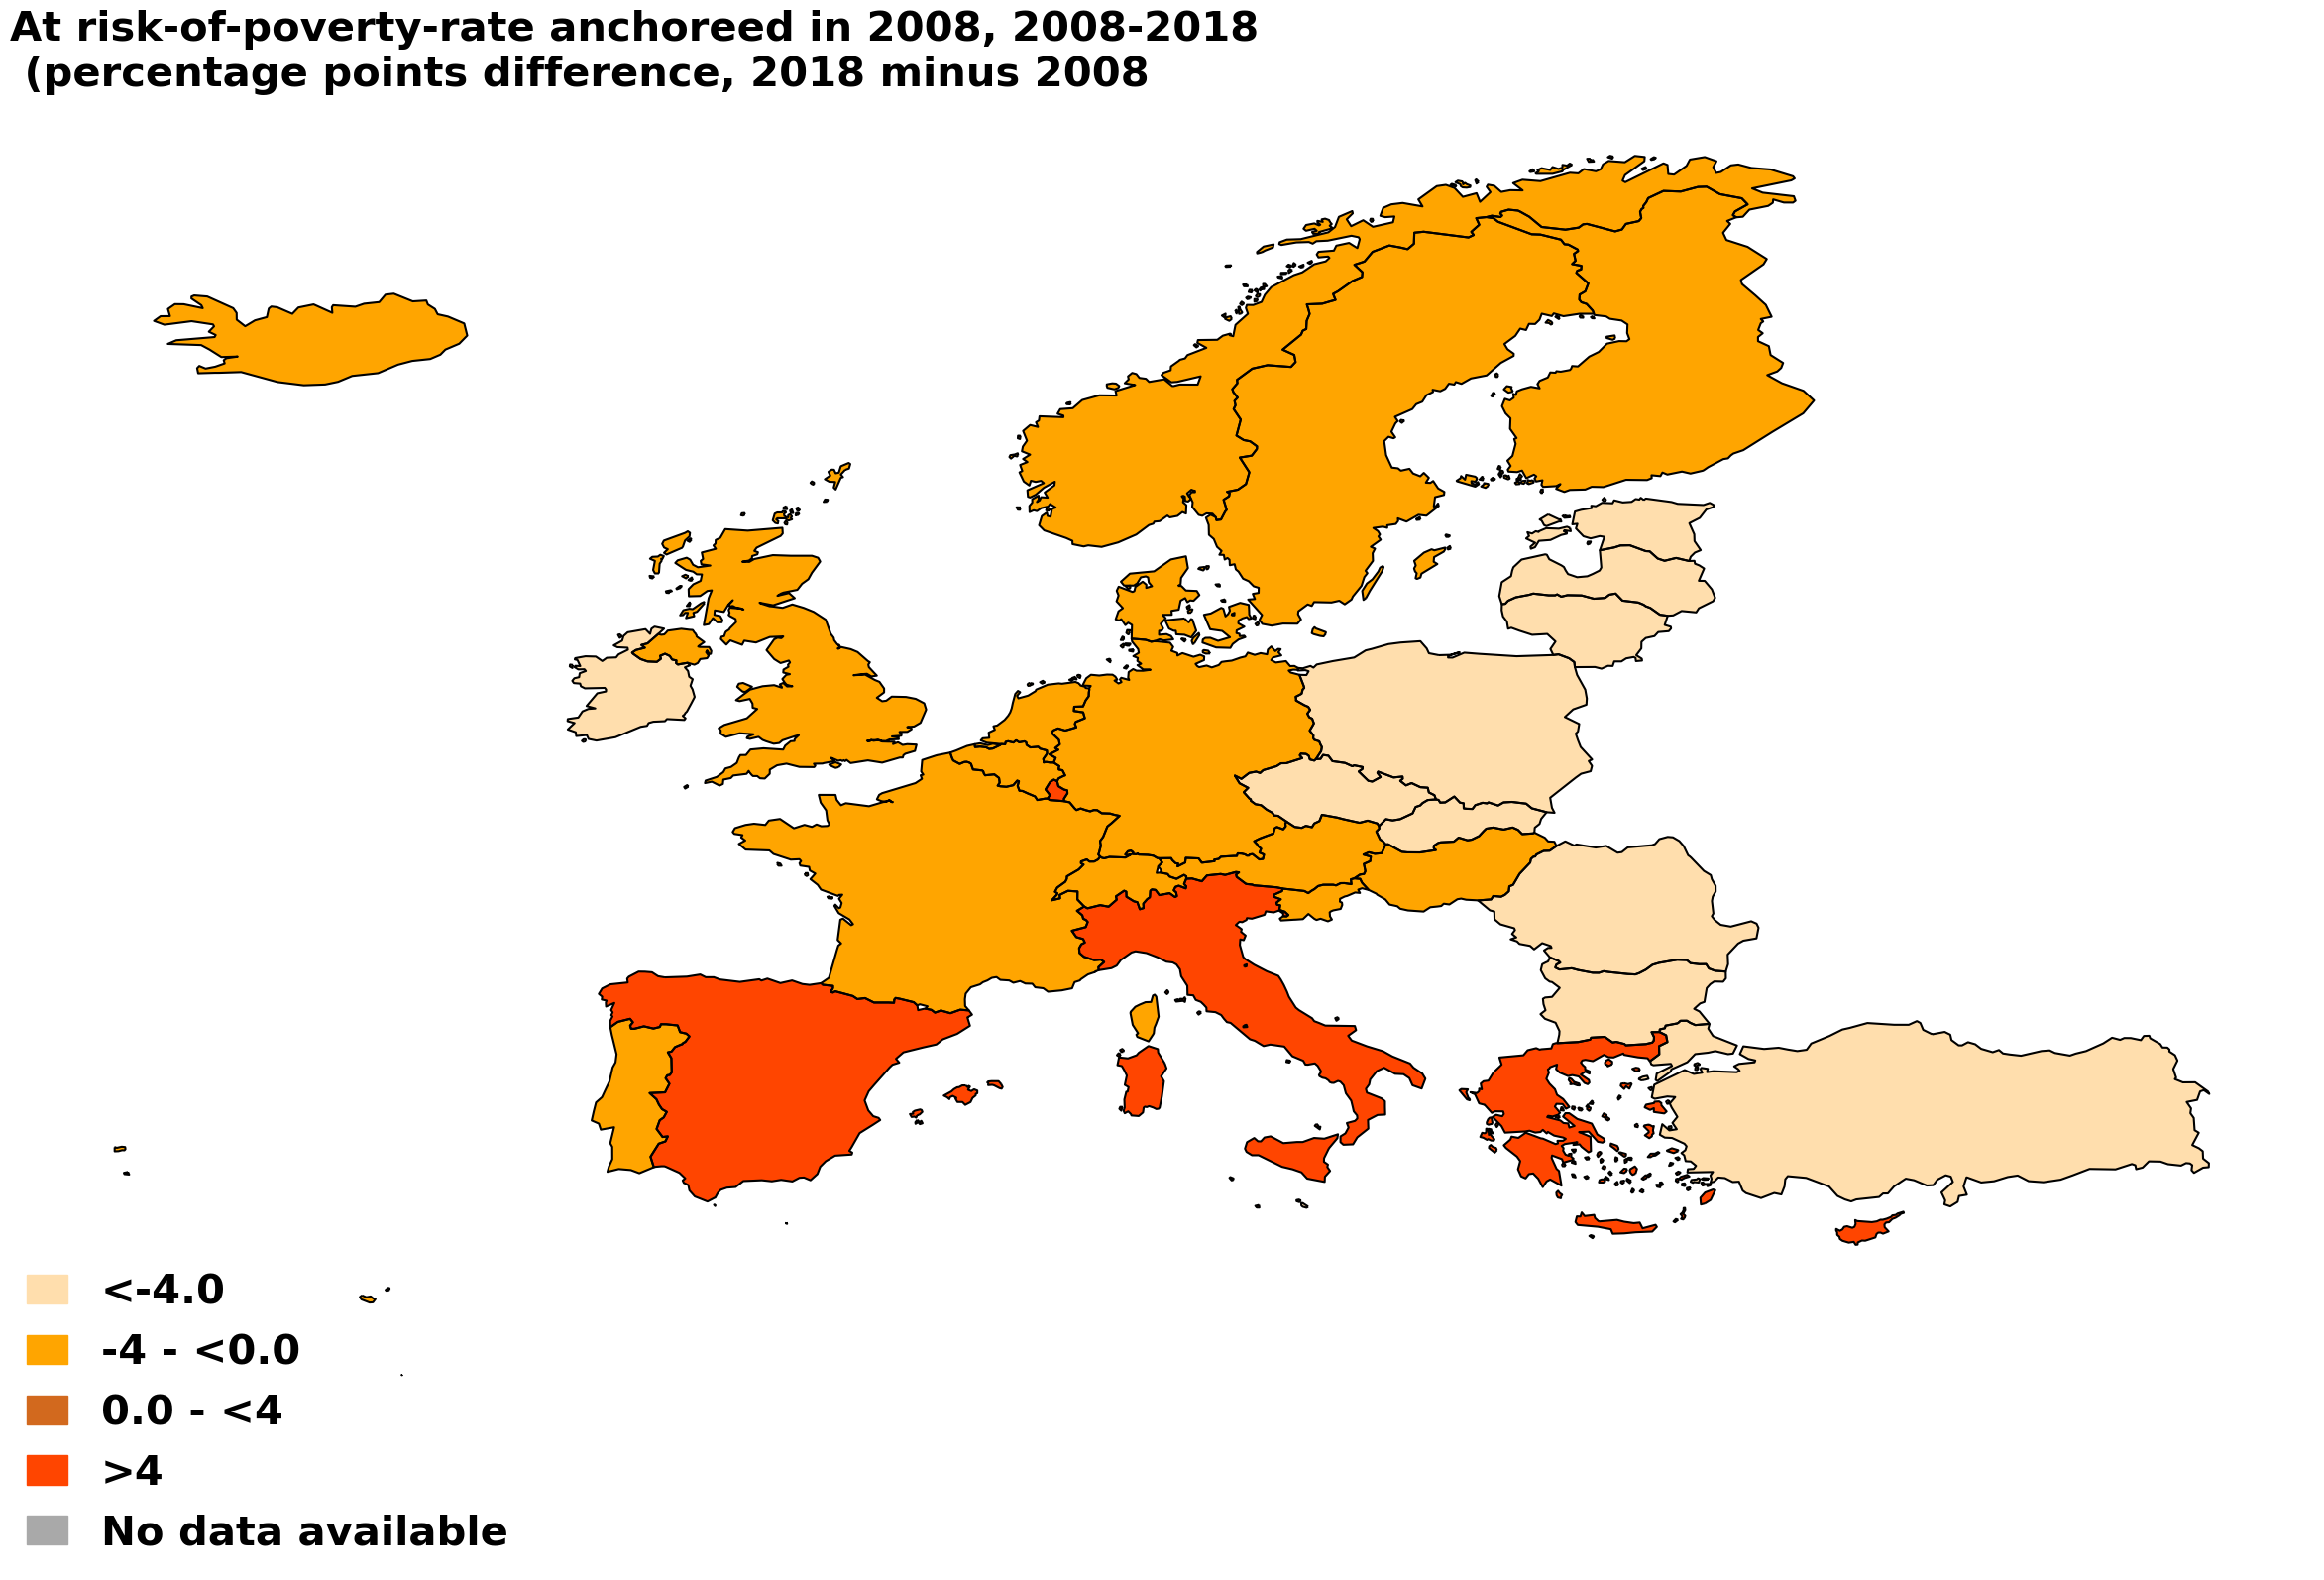

In [68]:
LEVEL = 0
crop = gpd.clip(income_nuts, EUclip)
# crop = nuts_death_data[LEVEL].intersection(EUclip.unary_union) 

f, ax = plt.subplots(1, figsize=(30, 25))
crop.plot(color=colors,ax=ax,  legend = True,
          legend_kwds = {'shrink':0.55},
          missing_kwds={ "color": "lightgrey", "alpha": 0.2, "edgecolor": "grey", "hatch": "///"}
         )
crop.boundary.plot(ax = ax, color = 'black')
ax.set_axis_off()
ax.set_title('At risk-of-poverty-rate anchoreed in 2008, 2008-2018 \n (percentage points difference, 2018 minus 2008'
             , fontsize=30, fontweight='bold', horizontalalignment = 'left', x = 0, y =1.05)
# f.tight_layout()
#f.subplots_adjust(hspace=0,wspace=-1)

#Create custom legend

orange_patch = mpatches.Patch(color='orange', label='-4 - <0.0 ')
orangered_patch = mpatches.Patch(color='orangered', label='>4')
navajowhite_patch = mpatches.Patch(color='navajowhite', label='<-4.0')
darkgrey_patch = mpatches.Patch(color='darkgrey', label='No data available')
chocolate_patch = mpatches.Patch(color='chocolate', label='0.0 - <4')

leg = ax.legend(handles=[navajowhite_patch, orange_patch,chocolate_patch,orangered_patch,darkgrey_patch],
                frameon=False, loc=(0, -0.1), ncol=1, 
                prop={'weight':'bold','size':'30'},labelspacing=0.5, handlelength=1);

## Final Remarks:

This notebook was a project conducted in the frame of the statistics-coded program of _Eurostat_. On the [github of the project](https://github.com/eurostat/statistics-coded/) you can find more statistics explained notebooks created by other EMOS students under the guidance of _Eurostat_'s staff. 